In [1]:
# Import everything needed to demonstrate ENSO oscillator.
from __future__ import division, print_function

import numpy as np

import ensosim as sim
from ensoplot import plot_output, clear_plots, plot_ensemble_output
import pylab as plt
%matplotlib inline

# Introduction to Model

In this notebook I will be investigating the bahviour of a simple model of ENSO oscillations. The model, due to [Jin (1996)](#References), is based on the idea of a recharge oscillator, where the Sea Surface Temperature (SST) and thermocline depth are coupled through the wind stress acting on the equatorial Pacific. This coupling acts in two ways, the first is a relatively quick, quasi-balance process whereby the wind stress acts to cause a gradient in the thermocline depth, such that a westerly wind stress anomaly leads to a deeper thermocline in the eastern Pacific. The second is a slower zonally integrated Sverdrup process, in which a westerly wind stress anomaly acts to decrease the depth thermocline over the western Pacific. The thermocline depth is also strongly related to the SST, with a deeper thermocline leading to warmer SSTs. This in turn affects the strength of the winds over the equatorial Pacific, with warmer SST over the western SST leading to a weakening of the Walker cell. The model captures these relationships as a coupled set of ordinary differential equations, relating the thermocline depth of the western Pacific to the SST of the eastern Pacific. 

A nonlinear term which represents the nonliner vertical distribution of the SST in the tropical upper ocean is added in. Following [Galanti and Tziperman (2000)](#References), an annual frequency is also added in for later parts of this project. The full equation set is as follows:

$\frac{dh}{dt} = -rh -\alpha bT - \alpha\xi$, (1)

$\frac{dT}{dt} = RT + \gamma h - \epsilon (h + bT)^3 + \gamma\xi$. (2)

In equation (1) $h$ is themocline depth in the western Pacific, $T$ is the SST in the eastern Pacific, $r$ is the damping of the upper ocean heat content, $\alpha$ links easterly wind stress anomolies to the recharge of upper ocean heat content, $b$ relates a thermocline gradient to eastery wind stress anomoly and $\xi$ is additional stochastic wind stress forcing. In equation (2) $R$ represents the Bjerknes positive feedback process, $\gamma$ relates thermocline gradient to SST gradient and $\epsilon$ represents the amount of nonlinearity in the system. For simplicity, all of these parameters have been non-dimensionalised by using suitable combinations of the scale SST, thermocline depth and time. The non-dimensionalised values of each of these parameters can be seen below in cell below.

In [2]:
# Calculate some periods. All values passed into enso_oscillator(...) are non-dimensionalised
# first and all output is also non-dimensionalised (so needs redimensionalising before e.g.
# plotting).
omega_c = np.sqrt(3/32)
tau_c = 2 * np.pi / omega_c
one_period = tau_c
five_periods = one_period * 5
print('one period: {} months'.format(one_period * sim.TIME_SCALE))
nt = 10000
# Load default settings and print ones that are relevant.
settings = sim.init_settings()
sim.print_settings(settings, ['T0', 'h0', 'mu0', 'b0', 'gamma', 'c', 'r', 'alpha'])

one period: 41.0415945652 months
T0: 0.15
h0: 0.0
mu0: 0.666666666667
b0: 2.5
gamma: 0.75
c: 1
r: 0.25
alpha: 0.125


# Numerical Schemes

Three numerical schemes were investigated, a backwards time (implicit) scheme, an forwards time (explicit) scheme and a 4th order Runge-Kutta (explicit) scheme.

## Backwards time

The backwards time scheme works by discretising equations (1) and (2) in space, and solving the resulting equations using a matrix solver. The discretised equations, simplified so that there is no annual forcing, nonlinearity or stochastic wind forcing, are:

$\frac{h^{n+1} - h^n}{\Delta h} = -rh^m - \alpha b T^m$, (3)

$\frac{T^{n+1} - T^n}{\Delta t} = RT^m + \gamma h^m$. (4)

A value of $m = n + 1$ is used, which means that to solve at time $t$ a 2x2 matrix must be inverted.

## Forward time

Equations (3) and (4) are used with a value of $m = n$, which permits solving for $h^{n+1}$ and $T^{n+1}$ explicitly.

## 4th order Runga-Kutta

Solving using a 4th order Runga-Kutta (RK4) involves calculating several intermediate values. First the right hand sides of equations (1) and (2) are written as functions of the $h$, $T$ and the relevant input parameters:

$\frac{dh}{dt} = f(T, h, r, \alpha, b,\xi)$, (5)

$\frac{dT}{dt} = g(T, h, R, \gamma, \epsilon, b, \xi)$. (6)

Next, eight intermediate values are calculated:

$k_1 = f(T, h, r, \alpha, b, \xi)$,

$l_1 = g(T, h, R, \gamma, \epsilon, b, \xi)$,

$k_2 = f(T + \frac{k_1 \Delta t}{2}, h + \frac{l_1 \Delta t}{2}, r, \alpha, b, \xi)$,

$l_2 = g(T + \frac{k_1 \Delta t}{2},  h + \frac{l_1 \Delta t}{2}, R, \gamma, \epsilon, b, \xi)$,

$k_3 = f(T + \frac{k_2 \Delta t}{2}, h + \frac{l_2 \Delta t}{2}, r, \alpha, b, \xi)$,

$l_3 = g(T + \frac{k_2 \Delta t}{2},  h + \frac{l_2 \Delta t}{2}, R, \gamma, \epsilon, b, \xi)$,

$k_4 = f(T + k_3 \Delta t, h + l_3 \Delta t, r, \alpha, b, \xi)$,

$l_4 = g(T + k_3 \Delta t,  h + l_3 \Delta t, R, \gamma, \epsilon, b, \xi)$. (7)

Finally, these values are used to work out values of $h$ and $T$ at the next timestep using the formulae:

$T^{n+1} = T^n + \frac{\Delta t}{6}(k_1 + 2 k2_ + 2 k_3 + k_4)$,

$h^{n+1} = h^n + \frac{\Delta t}{6}(l_1 + 2 l_2 + 2 l_3 + l_4)$. (8)

This numerical scheme requires more computation than either of the the others, but may yeild better results due to being able to use a longer timestep. 

## Comparison of Schemes

The ENSO oscillator can be run as it is in Task A with any of these schemes, and the results are shown in the cell below. A small value of the number of timesteps, $nt$, was used, to better demonstrate the ability of the RK4 scheme.

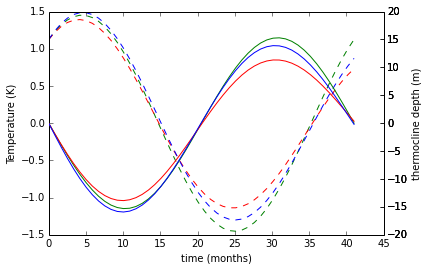

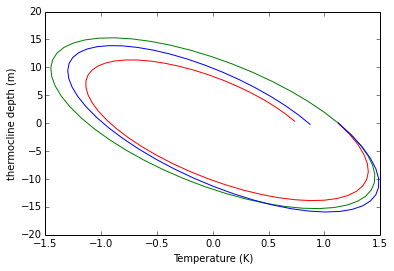

In [3]:
# Demonstration of 3 numerical schemes - Runge-Kutta 4th order (default)
# Backwards time 2nd order (bt)
# Forwards time 2nd order (ft)
settings = sim.init_settings()
nt = 50
plot_output(*sim.enso_oscillator(one_period, nt, **settings), colour='g')
settings['scheme'] = 'bt'
plot_output(*sim.enso_oscillator(one_period, nt, **settings), colour='r', clear=False)
settings['scheme'] = 'ft'
plot_output(*sim.enso_oscillator(one_period, nt, **settings), colour='b', clear=False)

#### Figure 1: Demonstration of 3 numerical schemes. Runge-Kutta 4th order (green) shows a periodic orbit that returns to its initial point. Backward time (red) is 2nd order accurate, and fails to return to its initial point. Forward time (blue) is also 2nd order accurate, and again fails to return to its initial point.

# Task A

When run with no nonlinearity, annual frequency or stochastic forcing, and when $\mu=2/3$, equations (1) and (2) can be solved analytically, and the solution is an ellipse in $T$, $h$ space. This ellipse can be clearly seen in Figure 1 for the RK4 scheme, but the Backwards time and Forwards time schemes both fail to return to their original positions after one period. This situation can be improved by using more timesteps, but this is not necessary to achieve very good accuracy using the RK4 scheme. All 3 schemes are stable though (with these parameters at least), as each case the size of the oscillation decreases or remains the same over the course of one period. This can be further demonstrated by running for more periods (not shown). In the rest of this project the RK4 scheme is used.

# Task B

setting: mu0=0.66, 
setting: mu0=0.67, 


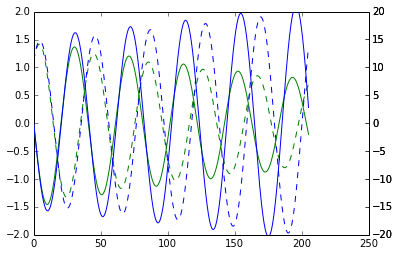

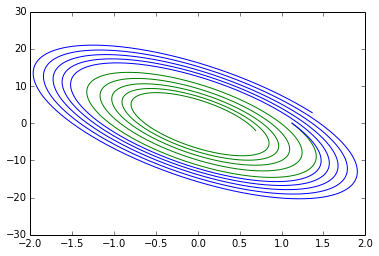

In [4]:
# Use a shorter delta t (by using more timesteps). Plot values of mu=0.66 and mu=0.67
# i.e. either side of mu=2/3 (critical mu value)
nt = 10000
settings = sim.init_settings(mu0=0.66)
plot_output(*sim.enso_oscillator(five_periods, nt, **settings), colour='g', clear=False)

settings = sim.init_settings(mu0=0.67)
plot_output(*sim.enso_oscillator(five_periods, nt, **settings), colour='b', clear=False)

#### Figure 2: using different values of $\mu$. Green is $\mu=0.66$ and blue is $\mu=0.67$, i.e. either side of the critical value of $\mu=2/3$. Both curves start at $T=1.125$, $h=0$.

Following [Jin (1996)](#References) and using the same simplified equations as in Task A, the eigen modes of the equations are given by:

$\sigma_{1,2} = -\frac{15}{16}(\frac{2}{3} - \mu \pm i \sqrt{(\mu - \mu_1)(\mu_2 - \mu)})$, (9)

$\mu_1 = (8 - \sqrt{28})/15$, $\mu_2 = (8 + \sqrt{28})/15$.

When $\mu=2/3$, the growth rate (the real part of $\sigma_{1,2}$) is $0$. When $\mu>2/3$, the growth rate is positive and the oscillations will increase in amplitude, as is seen in the blue curve in Figure 2. When $\mu<2/3$, the growth rate is negative and the oscillations will decrease in amplitude, as is seen in the green curve in Figure 2.

# Task C

setting: epsilon=0.1, 


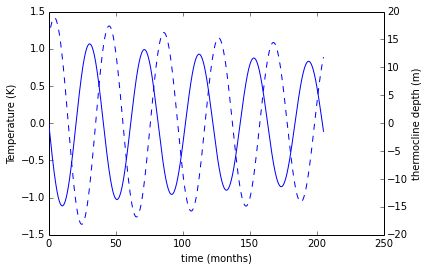

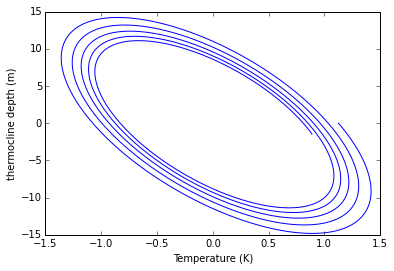

In [5]:
# Plot values of epsilon=0.1
settings = sim.init_settings(epsilon=0.1)
plot_output(*sim.enso_oscillator(five_periods, nt, **settings))

#### Figure 3: The effect of nonlinearity.

Enabling nonlinearity causes the oscillations to decrease in amplitude in a similar way to using $\mu=0.66$. However, the nonlinear nature of the decrease can be seen in way that the rate of decrease in amplitude decreases with each passing period.

setting: epsilon=0.1, mu0=0.67, 


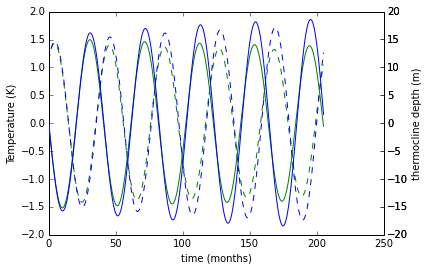

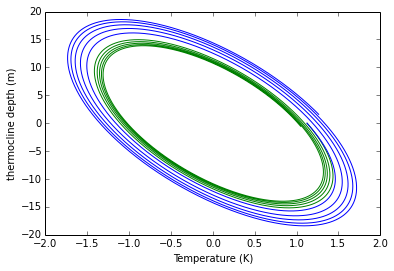

In [6]:
# Keep epsilon=0.1, plot mu=0.67 and mu=0.675.
settings = sim.init_settings(epsilon=0.1, mu0=0.67)
plot_output(*sim.enso_oscillator(five_periods, nt, **settings), colour='g')
settings['mu0'] = 0.675
plot_output(*sim.enso_oscillator(five_periods, nt, **settings), colour='b', clear=False)

#### Figure 4: The effect of changing $\mu$ with nonlinearity enabled.

As can be seen in Figure 4, the decrease in amplitude with each period with nonlinearity can be reduced by increasing $\mu$ slightly to $\mu=0.67$ (green), or even reversed by setting $\mu=0.675$.

# Task D

setting: mu_ann=0.2, epsilon=0.1, mode=annual_cycle, mu0=0.75, tau=6.0, 


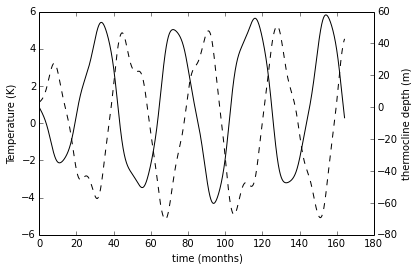

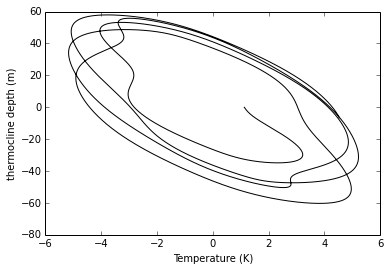

In [7]:
# Plot using an annual cycle forcing.
tau=12/sim.TIME_SCALE # N.B. non-dimensionalised
settings = sim.init_settings(epsilon=0.1, mu0=0.75, mu_ann=0.2, tau=tau,
                             mode='annual_cycle')
plot_output(*sim.enso_oscillator(one_period * 4, nt, **settings), ylim=(-80, 60), colour='k')

#### Figure 5: The effect of adding an annual frequency to the model.

Following [Galanti and Tziperman (2000)](#References), the coupling parameter $\mu$ is now varied annually using the following formula:

$\mu = \mu_0 ( 1 + \mu_{ann} cos(\frac{2 \pi t}{\tau} - \frac{5 \pi}{6}))$. (10)

$T$ and $h$ are now seen to be quasi-periodic, with a period still close to 41 months. $T$ now varies between $\pm$ 4 K, and $h$ now varies between $\pm$ 60 m, both much larger oscillations than before ($\pm$ 1.5 K and $\pm$ 15 m respectively).

# Task E

setting: tau=6.0, mu0=0.75, mu_ann=0.2, epsilon=0.1, tau_cor=0.0166666666667, f_ran=0.2, mode=annual_cycle, f_ann=0.02, 


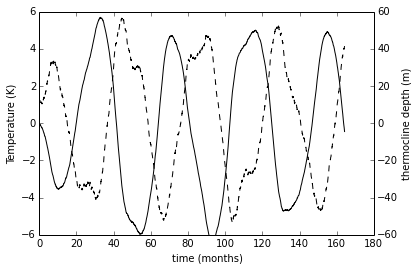

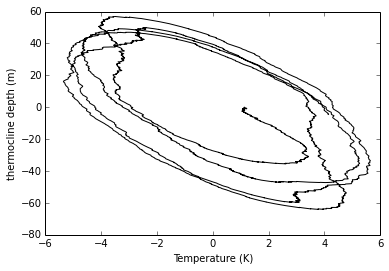

In [8]:
# Plot using annual cycle and stochastic forcing.
tau=12/sim.TIME_SCALE # N.B. non-dimensionalised
tau_cor=1/30/sim.TIME_SCALE # N.B. non-dimensionalised
settings = sim.init_settings(epsilon=0.1, mu0=0.75, mu_ann=0.2, tau=tau,
                             f_ann=0.02, f_ran=0.2, tau_cor=tau_cor,
                             mode='annual_cycle')
plot_output(*sim.enso_oscillator(one_period * 4, nt, **settings), ylim=(-60, 60), colour='k')

#### Figure 6: Adding a wind stress focing.

A stochastic wind stress forcing has been added to the model. The forcing is given by:

$\xi = f_{ann} cos(\frac{2 \pi t}{\tau}) + f_{ran} W \frac{\tau_{cor}}{\Delta t}$.

Here $W$ is a random number between $-1$ and $+1$, which takes a new value once in every period $\tau_{cor}$. $W$ represents a white noise process. The values of the parameters which have been set differently can be seen in the Python cell above.

The annual forcing causes a largeer amplitude, low frequency variation around the initial case of the ellipse. The amplitude is still smaller than the range of values encompassed by the phase space though. The stochastic wind stress forcing causes a small amplitude, high frequency variation or jitter around the annually forcing trajectory.

# Task F

setting: tau=6.0, mu0=0.75, mu_ann=0.2, epsilon=0.1, tau_cor=0.0166666666667, f_ran=0.2, mode=annual_cycle, f_ann=0.02, 


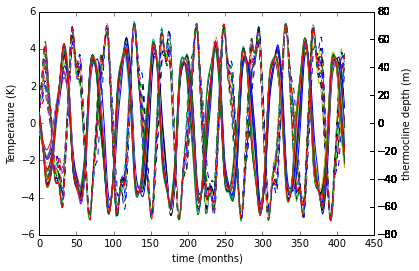

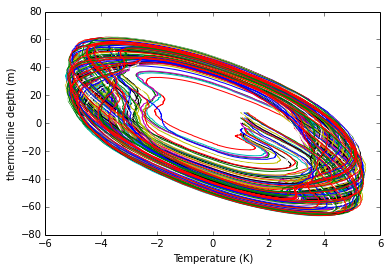

In [9]:
# Demonstration of sensitivity of ensembles of runs.
nperiods = 10
# Set dt to one day by calculating nt correspondingly.
nt = int(one_period * nperiods * 30)
tau=12/sim.TIME_SCALE # N.B. non-dimensionalised
tau_cor=1/30/sim.TIME_SCALE # N.B. non-dimensionalised
settings = sim.init_settings(epsilon=0.1, mu0=0.75, mu_ann=0.2, tau=tau,
                             f_ann=0.02, f_ran=0.2, tau_cor=tau_cor,
                             mode='annual_cycle')

results = sim.run_enso_ensemble(one_period * nperiods, nt, settings, h0_min=-0.05, h0_max=0.05)
plot_ensemble_output(results)

#### Figure 7: sensitivity of the model to perturbations in the initial conditions. The initial conditions can be seen as the 25 starting points of the trajectories from $T=1$ to $T=1.25$, $h=-7.5$ to $h=7.5$. The model was run for 10 periods.

Figure 7 shows the lack of sensitivity of the model when using the same parameters used in Task E. The initial conditions were perturbed by a small amount from the values used in Task E, from $T=1$ to $T=1.25$, $h=-7.5$ to $h=7.5$, with 5 values in each range giving a value of 25 ensemble members. Each member was run for 10 periods of 41.04 months. The ensemble members start off close to each other, and continue to remain coherent with each other over the course of the run, as can be seen most clearly in the top plot of Figure 7. This demonstrates a lack of sensitivity to the initial conditions.

In [10]:
# Settings as used by the following ensemble runs.
nperiods = 10
# Set dt to one day by calculating nt correspondingly.
nt = int(one_period * nperiods * 30)
tau=12/sim.TIME_SCALE # N.B. non-dimensionalised
tau_cor=1/30/sim.TIME_SCALE # N.B. non-dimensionalised
settings = sim.init_settings(T0=0.5/sim.T_SCALE, epsilon=3, mu0=0.7, mu_ann=0.2, tau=tau,
                             f_ann=0.02, f_ran=0.2, tau_cor=tau_cor,
                             mode='annual_cycle')

setting: tau=6.0, mu0=0.7, mu_ann=0.2, epsilon=3, T0=0.0666666666667, tau_cor=0.0166666666667, f_ran=0.2, mode=annual_cycle, f_ann=0.02, 


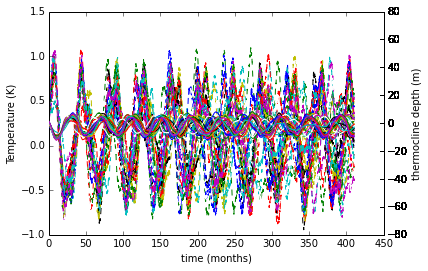

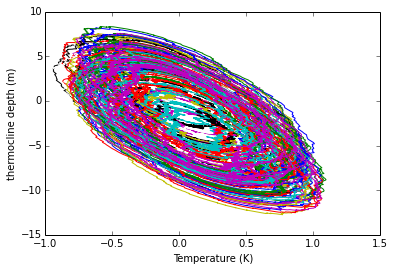

In [11]:
# Demonstration of the sensitivity of the system to small changes in h, T.
results = sim.run_enso_ensemble(one_period * nperiods, nt, settings, 
                                h0_min=-1.5/sim.H_SCALE, h0_max=1.5/sim.H_SCALE,
                                T0_min=0.4/sim.T_SCALE, T0_max=0.6/sim.T_SCALE)
plot_ensemble_output(results)

#### Figure 8: sensitivity of the model with different parameters. The parameters are set as per the cell 2 above, and the initial conditions are as per the cell above.

With some experimentation with the parameters, the sensitivity of the model to changes in its initial conditions can be seen. Without further investigation, this may look like chaotic behaviour, but chaos can only be exhibited in deterministic systems, of which this is not, due to the stochastic nature of the wind stress forcing. Therefore, although one can say that the model is sensitive to its initial conditions, one cannot say that it is chaotic. This will be demonstrated in two ways below: first by running the model with the above parameters and no changes in its initial conditions, and second by running the model with changes to its initial conditions but the same wind stress forcing for each run (i.e. it is still randomly generated, but it is the same random sequence for each run).

setting: tau=6.0, mu0=0.7, mu_ann=0.2, epsilon=3, T0=0.0666666666667, tau_cor=0.0166666666667, f_ran=0.2, mode=annual_cycle, f_ann=0.02, 


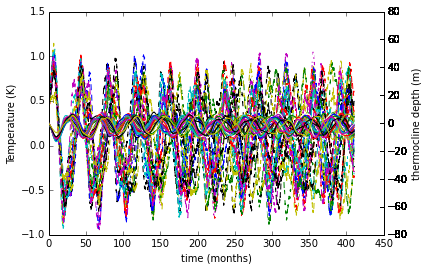

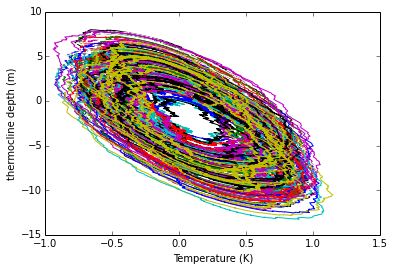

In [12]:
# Demonstration of the sensitivity of the system when *no* change in T, h.
# N.B. same settings as above used.
settings = sim.init_settings(T0=0.5/sim.T_SCALE, epsilon=3, mu0=0.7, mu_ann=0.2, tau=tau,
                             f_ann=0.02, f_ran=0.2, tau_cor=tau_cor,
                             mode='annual_cycle')

results = sim.run_enso_ensemble(one_period * nperiods, nt, settings, 
                                h0_min=0.0, h0_max=0.0, 
                                T0_min=0.5/sim.T_SCALE, T0_max=0.5/sim.T_SCALE)
plot_ensemble_output(results)

#### Figure 9: sensitivity of simulation when the same initial conditions are used for each run.

As can be seen in Figure 9, even when exactly the same initial conditions are used, the model still shows large variation in its ensemble members after 10 periods. This violates one of the criteria for a chaotic system, that it must produce the same result when run with the same initial conditions.

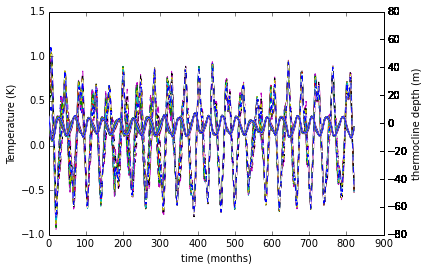

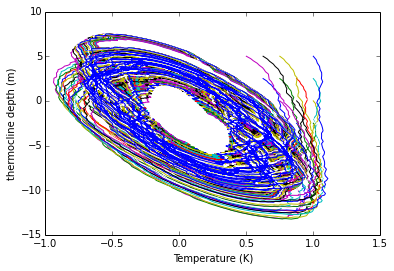

In [13]:
# Demonstration of lack of sensitivity if same stochasitic forcing used for each ensemble member.
# N.B. same settings as above used.
results = sim.run_enso_ensemble(one_period * 20, nt, settings, 
                                h0_min=-5/sim.H_SCALE, h0_max=5/sim.H_SCALE,
                                T0_min=0.5/sim.T_SCALE, T0_max=1/sim.T_SCALE, 
                                reseed=True)
plot_ensemble_output(results)

#### Figure 10: sensitivity of model when the same wind stress forcing is used and the initial conditions are perturbed over quite a large range.

As can be seen in the top plot if Figure 10, when the wind stress forcing is the same for each ensemble member, and even when quite a large range of initial conditions are used, the ensemble members converge onto a similar trajectory after a long enough time (20 periods in this case). This again shows that the model is not chaotic when run in a purely deterministic way with a wind stress forcing that is the same for each ensemble member.

## References

Galanti, E., & Tziperman, E. (2000). ENSO's phase locking to the seasonal cycle in the fast-SST, fast-wave, and mixed-mode regimes. Journal of the atmospheric sciences, 57(17), 2936-2950.

Jin, F. F. (1996). Tropical ocean-atmosphere interaction, the Pacific cold tongue, and the El Niño-Southern Oscillation. Science, 274(5284), 76.